# Market Regime Detection

This notebook implements the Kolmogorov-Smirnov (KS) method as proposed by Gómez-Águila et al. (2022) to estimate the Hurst exponent ($H$) of the S&P 500 index and the XEQT ETF.

The Hurst exponent is a measure of long-term memory in time series:
*   $H < 0.5$: Anti-persistent (mean-reverting)
*   $H = 0.5$: Uncorrelated (random walk)
*   $H > 0.5$: Persistent (trending).

Traditional methods like Rescaled Range ($R/S$) often fail with financial data due to heavy-tailed distributions. This notebook utilizes the KS-GHE(1) method, which identifies $H$ by minimizing the Kolmogorov-Smirnov distance between empirical distributions at different scales.

In [50]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats, optimize

## KS-GHE(1) Implementation Based on Gómez-Águila et al. (2022)

In [51]:
def samples_GHE(serie, tau):
    return np.abs(serie[tau:] - serie[:-tau])

def samples_TA(serie, tau):
    "Calculates triangle areas for self-similarity testing"
    # Vertices at t, t+tau, and t+2tau
    return (tau / 2.0) * np.abs(serie[2*tau:] - 2*serie[tau:-tau] + serie[:-2*tau])

def KSGHE(serie):
    scaling_range = [2**n for n in range(int(np.log2(len(serie) / 8)) + 1)]

    # Reference distribution at tau=1
    sample_t0 = samples_GHE(serie, scaling_range[0])

    # Minimize the sum of Kolmogorov-Smirnov distances
    # We find the H that makes distributions at different taus match the tau=1 distribution.
    def objective(h):
        return np.sum([
            stats.ks_2samp(sample_t0, samples_GHE(serie, tau) / (tau**h)).statistic
            for tau in scaling_range[1:]
        ])

    # Coarse Grid Search
    grid = np.linspace(0.1, 0.9, 18)
    grid_results = [objective(h) for h in grid]
    best_initial_guess = grid[np.argmin(grid_results)]

    # 2. Nelder-Mead to polish the result
    w = optimize.fmin(objective, x0=best_initial_guess, disp=False)
    h_est = np.clip(w[0], 0.01, 0.99)
    return h_est

def self_similarity_test_TA(serie, h_est):
    scaling_range = [2**n for n in range(int(np.log2(len(serie) / 8)) + 1)]

    # Reference distribution is AT(1)
    at1 = samples_TA(serie, 1)
    p_vals = []

    for tau in scaling_range[1:]:
        # Scale triangle areas by tau^(H+1)
        # Use disjoint samples (step size = tau) as required
        at_tau_scaled = samples_TA(serie, tau)[::tau] / (tau**(h_est + 1))
        _, p = stats.ks_2samp(at1, at_tau_scaled)
        p_vals.append(p)

    return min(p_vals)

def classify_regime(h, price, ma200, p_val, h_high=0.55, h_low=0.45, p_threshold=0.01):
    """
    Classifies market regime based on Hurst exponent, 200-day MA direction, and self-similarity.

    Returns a signal string and a numeric position size (0 to 1).
      1.0  = fully invested
      0.5  = half position
      0.0  = out of market

    Rules:
      - Self-similarity rejected (p < threshold): UNCERTAIN -> 0.0
      - H > h_high AND price > MA200:             TRENDING UP -> ~1.0
      - H > h_high AND price < MA200:             TRENDING DOWN -> 0.0
      - h_low <= H <= h_high:                     CHOPPY -> 0.5
      - H < h_low:                                MEAN-REVERTING -> 0.0
    """
    # Reject if self-similarity fails
    if p_val < p_threshold:
        return "UNCERTAIN", 0.0

    # Only go long if price is above MA (trending up)
    if h >= h_high and price <= ma200:
        return "TRENDING DOWN", 0.0

    if h_low <= h < h_high:
        return "CHOPPY", 0.5

    if h < h_low:
        return "MEAN-REVERTING", 0.0

    # H confidence: how far above h_high, scaled to [0, 1]
    h_confidence = np.clip((h - h_high) / (0.9 - h_high), 0.0, 1.0)

    # P-value confidence: log-scale between threshold and 0.5
    p_confidence = np.clip(np.log(p_val / p_threshold) / np.log(0.5 / p_threshold), 0.0, 1.0)

    # Combined size: scaled geometric mean of the two confidences
    position = np.clip((np.sqrt(h_confidence * p_confidence) + 1) / 2, 0.5, 1.0)

    return "TRENDING UP", round(position, 2)

  ^GSPC
  Annualised Return  — Strategy: 6.2%   Buy & Hold: 12.7%
  Max Drawdown       — Strategy: -14.2%   Buy & Hold: -20.1%
  Signal distribution: {'TRENDING DOWN': 8, 'UNCERTAIN': 1, 'CHOPPY': 13, 'TRENDING UP': 41}


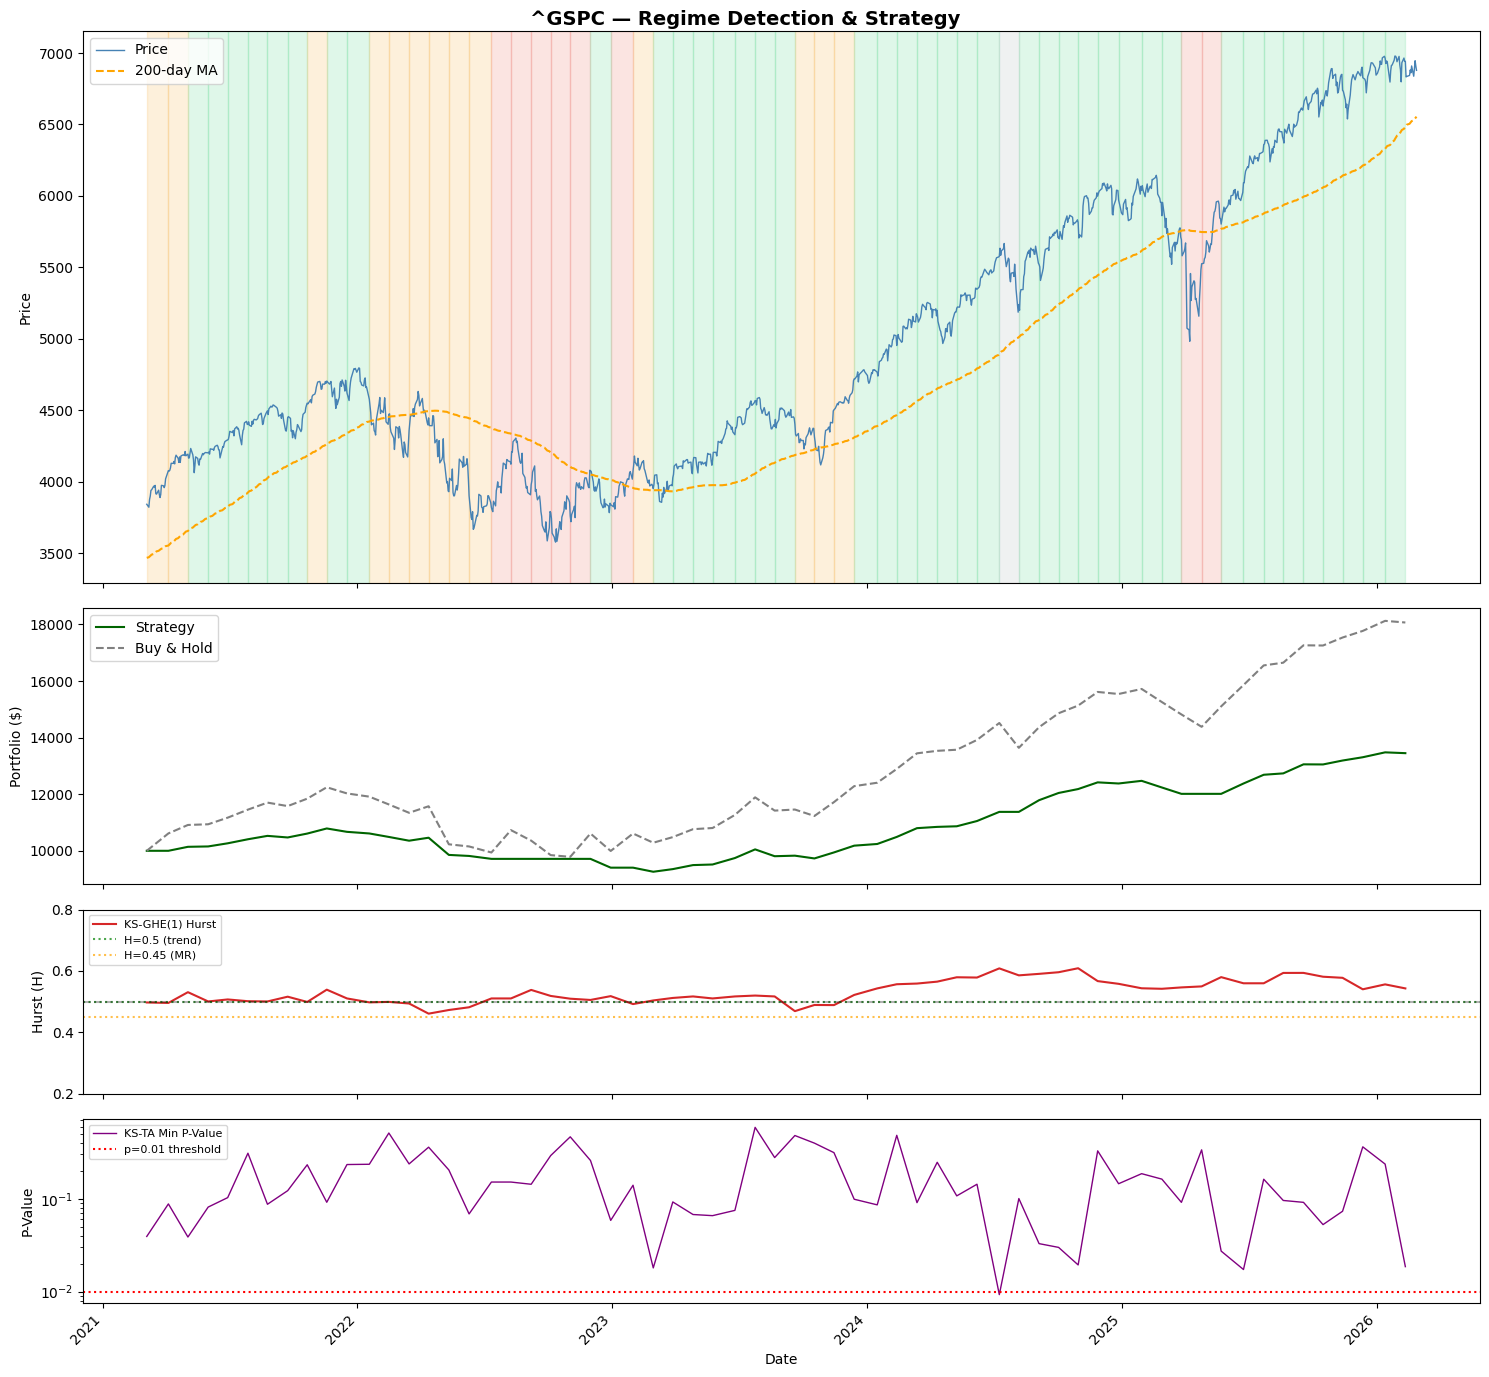

  ── TODAY'S SIGNAL (2026-02-11) ──
  Hurst (H):          0.543
  Self-similarity p:  0.0186  (OK)
  Regime:             TRENDING UP
  Recommended pos:    56% invested
  XEQT.TO
  Annualised Return  — Strategy: 6.5%   Buy & Hold: 13.1%
  Max Drawdown       — Strategy: -9.1%   Buy & Hold: -17.5%
  Signal distribution: {'TRENDING DOWN': 7, 'UNCERTAIN': 5, 'CHOPPY': 11, 'TRENDING UP': 40}


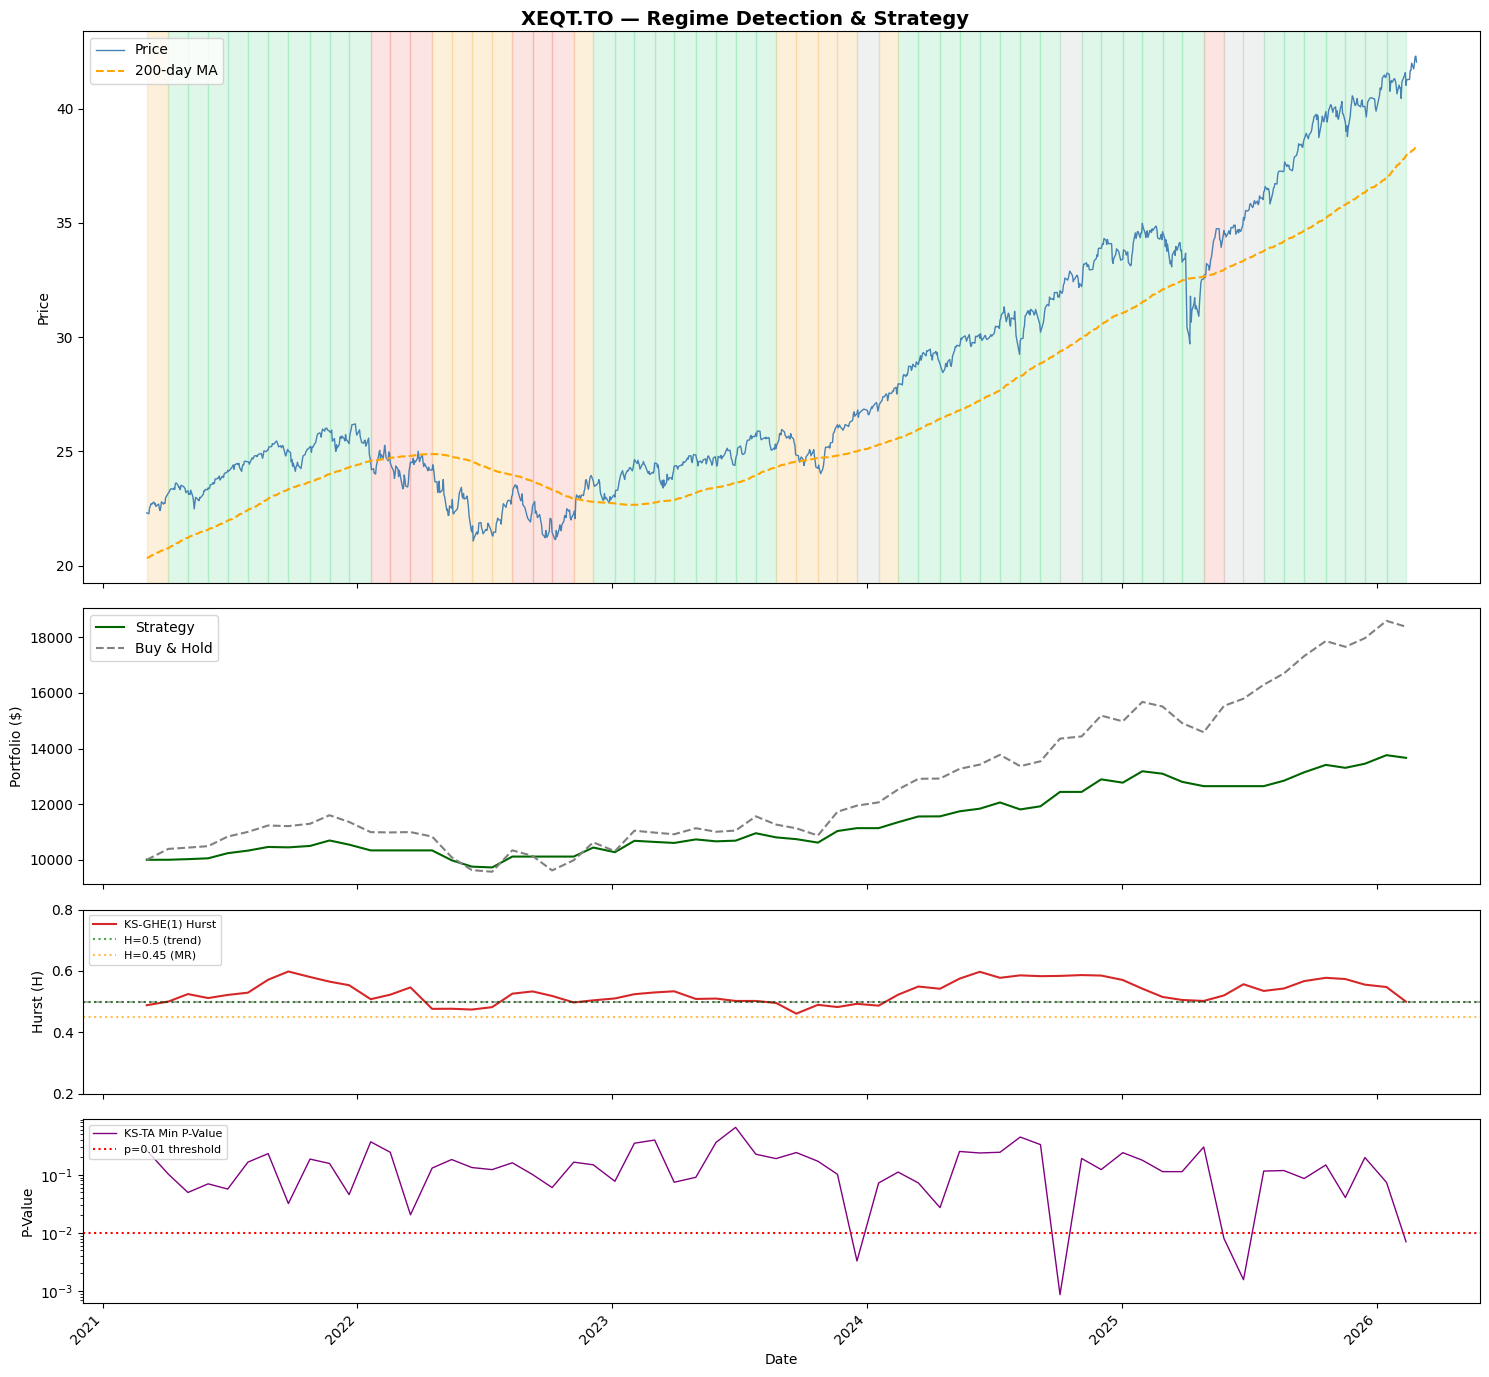

  ── TODAY'S SIGNAL (2026-02-12) ──
  Hurst (H):          0.500
  Self-similarity p:  0.0070  (REJECTED)
  Regime:             UNCERTAIN
  Recommended pos:    0% invested


In [52]:
# ── Parameters ────────────────────────────────────────────────────────────────
TICKERS     = ["^GSPC", "XEQT.TO"]
BENCHMARK   = "XEQT.TO"    # buy-and-hold benchmark
WINDOW      = 256          # rolling Hurst window (trading days)
STEP        = 20           # recalculation frequency (trading days)
MA_WINDOW   = 200          # moving average for trend direction
H_HIGH      = 0.50         # threshold: trending
H_LOW       = 0.45         # threshold: mean-reverting
P_THRESH    = 0.01         # self-similarity rejection level
INITIAL_CAP = 10_000       # starting capital ($)

# ── Main loop ─────────────────────────────────────────────────────────────────
for ticker in TICKERS:
    print(f"{'='*60}")
    print(f"  {ticker}")
    print(f" {'='*60}")

    data = yf.download(ticker, period="6y", auto_adjust=True, progress=False)
    if data.empty:
        print(f"  No data found for {ticker}, skipping.")
        continue

    prices = data["Close"].squeeze()
    log_prices = np.log(prices).values
    ma200 = prices.rolling(MA_WINDOW).mean().shift(1)

    # ── Rolling Hurst + regime classification ─────────────────────────────────
    dates, h_vals, p_vals, signals, positions = [], [], [], [], []

    for i in range(0, len(log_prices) - WINDOW, STEP):
        window_data = log_prices[i : i + WINDOW]
        end_idx     = i + WINDOW

        h   = KSGHE(window_data)
        p   = self_similarity_test_TA(window_data, h)
        price_now = prices.iloc[end_idx]
        ma_now    = ma200.iloc[end_idx]

        signal, pos = classify_regime(h, price_now, ma_now, p, H_HIGH, H_LOW, P_THRESH)

        dates.append(prices.index[end_idx])
        h_vals.append(h)
        p_vals.append(p)
        signals.append(signal)
        positions.append(pos)

    # ── Backtest ──────────────────────────────────────────────────────────────
    # Strategy: at each step date, set position to signal's recommended size.
    # Between steps, hold current position. Compare to buy-and-hold.

    strat_values  = [INITIAL_CAP]
    bnh_values    = [INITIAL_CAP]
    strat_units   = 0.0   # units of the asset held
    current_pos   = 0.0   # fraction invested

    # Build a daily price series aligned to our step dates for the backtest
    price_at_dates = prices.reindex(dates, method="nearest")

    for j in range(1, len(dates)):
        prev_price = price_at_dates.iloc[j - 1]
        curr_price = price_at_dates.iloc[j]
        daily_return = curr_price / prev_price

        # Update strategy value based on previous position
        prev_val = strat_values[-1]
        invested = prev_val * current_pos
        cash     = prev_val * (1 - current_pos)
        new_val  = invested * daily_return + cash
        strat_values.append(new_val)

        # Update buy-and-hold value
        bnh_values.append(bnh_values[-1] * daily_return)

        # Apply new signal for next period
        current_pos = positions[j]

    strat_series = pd.Series(strat_values, index=dates)
    bnh_series   = pd.Series(bnh_values,   index=dates)

    # ── Performance metrics ───────────────────────────────────────────────────
    def max_drawdown(series):
        roll_max = series.cummax()
        drawdown = (series - roll_max) / roll_max
        return drawdown.min()

    def annualised_return(series):
        n_years = (series.index[-1] - series.index[0]).days / 365.25
        return (series.iloc[-1] / series.iloc[0]) ** (1 / n_years) - 1

    strat_ret  = annualised_return(strat_series)
    bnh_ret    = annualised_return(bnh_series)
    strat_mdd  = max_drawdown(strat_series)
    bnh_mdd    = max_drawdown(bnh_series)

    print(f"  Annualised Return  — Strategy: {strat_ret*100:.1f}%   Buy & Hold: {bnh_ret*100:.1f}%")
    print(f"  Max Drawdown       — Strategy: {strat_mdd*100:.1f}%   Buy & Hold: {bnh_mdd*100:.1f}%")
    print(f"  Signal distribution: { {s: signals.count(s) for s in set(signals)} }")

    # ── Plotting ──────────────────────────────────────────────────────────────
    regime_colors = {
        "TRENDING UP":   "#2ecc71",
        "TRENDING DOWN": "#e74c3c",
        "CHOPPY":        "#f39c12",
        "MEAN-REVERTING":"#3498db",
        "UNCERTAIN":     "#95a5a6",
    }

    fig, axes = plt.subplots(4, 1, figsize=(15, 14), sharex=True,
                             gridspec_kw={'height_ratios': [3, 1.5, 1, 1]})
    fig.suptitle(f"{ticker} — Regime Detection & Strategy", fontsize=14, fontweight='bold')

    for ax in axes:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        ax.xaxis.set_major_locator(mdates.YearLocator(1))

    plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')

    # Panel 1: Price + 200MA + regime shading
    ax1 = axes[0]
    ax1.plot(prices.loc[dates[0]:], color='steelblue', linewidth=1, label='Price')
    ax1.plot(ma200.loc[dates[0]:],  color='orange', linewidth=1.5, linestyle='--', label='200-day MA')
    for j in range(len(dates) - 1):
        ax1.axvspan(dates[j], dates[j+1],
                    color=regime_colors.get(signals[j], '#cccccc'), alpha=0.15)
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')

    # Panel 2: Equity curves
    ax2 = axes[1]
    ax2.plot(strat_series, color='darkgreen', linewidth=1.5, label='Strategy')
    ax2.plot(bnh_series,   color='gray',      linewidth=1.5, linestyle='--', label='Buy & Hold')
    ax2.set_ylabel('Portfolio ($)')
    ax2.legend(loc='upper left')

    # Panel 3: Rolling Hurst
    ax3 = axes[2]
    ax3.plot(dates, h_vals, color='tab:red', linewidth=1.5, label='KS-GHE(1) Hurst')
    ax3.axhline(H_HIGH, color='green',  linestyle=':', alpha=0.7, label=f'H={H_HIGH} (trend)')
    ax3.axhline(0.5,    color='black',  linestyle='--', alpha=0.3)
    ax3.axhline(H_LOW,  color='orange', linestyle=':', alpha=0.7, label=f'H={H_LOW} (MR)')
    ax3.set_ylim(0.2, 0.8)
    ax3.set_ylabel('Hurst (H)')
    ax3.legend(loc='upper left', fontsize=8)

    # Panel 4: Self-similarity p-value
    ax4 = axes[3]
    ax4.plot(dates, p_vals, color='purple', linewidth=1, label='KS-TA Min P-Value')
    ax4.axhline(P_THRESH, color='red', linestyle=':', label=f'p={P_THRESH} threshold')
    ax4.set_yscale('log')
    ax4.set_ylabel('P-Value')
    ax4.set_xlabel('Date')
    ax4.legend(loc='upper left', fontsize=8)

    fig.tight_layout()
    plt.show()

    # ── Today's signal ───────────────────────────────────────────────────────
    print(f"  ── TODAY'S SIGNAL ({dates[-1].date()}) ──")
    print(f"  Hurst (H):          {h_vals[-1]:.3f}")
    print(f"  Self-similarity p:  {p_vals[-1]:.4f}  {'(REJECTED)' if p_vals[-1] < P_THRESH else '(OK)'}")
    print(f"  Regime:             {signals[-1]}")
    print(f"  Recommended pos:    {int(positions[-1]*100)}% invested")
